---
title: EOPF Zarr Data Access with openEO and STAC 
subtitle: Learn how to use the EOPF Zarr data through STAC and openEO
authors:
  - name: Peter Zellner
    orcid: 0000-0002-3394-9664
    github: przell
    affiliations:
      - id: DLR
        institution: German Aerospace Center
        ror: 04bwf3e34
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-01-29
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords: ["earth observation", "remote sensing"]
tags: ["openeo"]
releaseDate: 2025-08-29
datePublished: 2025-09-24
dateModified: 2025-08-29
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of contents

- [Introduction](#Introduction)
- [Setup](#Setup)
- [Connect to openEO](#Connect-to-openEO)
- [Load a virtual data cube](#Load-a-virtual-data-cube)
- [Create a processing workflow](#Create-a-processing-workflow)
- [Compare to the SAFE format](#Compare-to-the-SAFE-format)

(Introduction)=
## Introduction

This is a practical introduction to accessing and processing EOPF Zarr products via STAC and the openEO API, a unified interface that makes Earth Observation workflows more standardised, portable, and reproducible.

:::{hint} Overview

- Introdcution on how to use openEO with the new EOPF Zarr format
- Exploiting interoperability between the new EOPF Zarr format, STAC and the openEO API
- Creating a portable and reproducible workflow

- Accessing EOPF Zarr data with openEO
- Creating customised virtual data cubes
- Running simple processing workflows

:::

(Setup)=
## Setup
Start importing the necessary libraries

https://github.com/EOPF-Sample-Service/eopf-sample-notebooks/issues/85#issuecomment-3248646739

```
cd workspace

git clone https://github.com/suriyahgit/openeo-processes-dask/ -b xcube_beta --recurse-submodules
cd openeo-processes-dask
pip install .[implementations]

cd

git clone https://github.com/clausmichele/openeo-pg-parser-networkx.git -b update_python
cd openeo-pg-parser-networkx
pip install .

cd

pip install distributed==2025.1.0 openeo
```

In [1]:
import os
os.environ["OPENEO_CONFIG_HOME"]= "/home/jovyan/workspace/"

In [2]:
from openeo.local import LocalConnection

Did not load machine learning processes due to missing dependencies: Install them like this: `pip install openeo-processes-dask[implementations, ml]`


In [3]:
#import openeo
import rioxarray as rxr
import matplotlib.pyplot as plt
from xcube_eopf.utils import reproject_bbox

mkdir -p failed for path /home/jovyan/.config/matplotlib: [Errno 13] Permission denied: '/home/jovyan/.config/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-brotiffh because there was an issue with the default path (/home/jovyan/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


(Connect-to-openEO)=
## Connect to openEO
Connect to an openEO backend

In [4]:
connection = LocalConnection("./")

In [4]:
#connection_url = "openeo.dataspace.copernicus.eu"
#connection_url = "https://openeo.eodc.eu/" # this is throwing an 504 failed to parse error message in the first .download
#connection = openeo.connect(connection_url).authenticate_oidc()

For more information on how to ues openEO refer to the tutorials [here](https://openeo.org/documentation/0.4/getting-started.html).

(Load-a-virtual-data-cube)=
## Load a virtual data cube
First, we'll define the extents in time and space and the bands we are interested in

In [5]:
bbox = [9.51394272720868, 53.52777389917263, 9.856775345771272, 53.77590598108809] # munich
bbox = [9.669372670305636, 53.64026948239441, 9.701345402674315, 53.66341039786631] # 265 px northern germany
time_range = ['2025-05-01', '2025-06-01']

Define the url to the STAC resource you want to query.

In [7]:
stac_url = "https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a"
bands = ["b02", "b08"] # bandnames are specific to the STAC Catalogs

Reproject the bbox to the native crs of the STAC items, so that xcube-eopf does not trigger reprojection internally.

In [8]:
crs_reprj = "EPSG:32632" # what if multiple zones are required?
bbox_reprj = reproject_bbox(bbox, "EPSG:4326", crs_reprj)

spatial_extent_reprj = {
    "west": bbox_reprj[0],
    "south": bbox_reprj[1],
    "east": bbox_reprj[2],
    "north": bbox_reprj[3], 
    "crs" : crs_reprj
}

Load the data cube via the funtion `load_stac()` and insert the extents.

In [9]:
%%time
cube = connection.load_stac(
    url=stac_url,
    spatial_extent = spatial_extent_reprj,
    temporal_extent=time_range,
    bands=bands,
)

CPU times: user 5.05 s, sys: 233 ms, total: 5.29 s
Wall time: 39.9 s


Inspect the `load_stac()` process visually.

In [10]:
cube

(Create-a-processing-workflow)=
## Create a processing workflow
Apply processing. We're calculating the NDVI. And getting a monthly mean.

In [11]:
red = cube.band(bands[0])
nir = cube.band(bands[1])
cube_ndvi = (nir - red) / (nir + red)
cube_mnth = cube_ndvi.reduce_dimension(dimension="time", reducer="mean")

Inspect the worflow visually.

In [12]:
cube_mnth

Start the processing through a synchronous call and stream the result into the environment. *Note: Currently we are using the local processing version of openEO. It is not sending any requests to an actual backend. It is converting the openEO process graph to an executable Python code. It's interacting only with the STAC API and the data buckets.*

In [13]:
%%time
# reprj bbox: 28.8 s / 16 s / 14 s
# lat/lon bbox: 
res = cube_mnth.execute()

CPU times: user 3.11 s, sys: 98.4 ms, total: 3.21 s
Wall time: 14.5 s


Inspect the dimensions of the data cube.

In [14]:
res

<xarray.DataArray (y: 261, x: 215)> Size: 449kB
dask.array<mean_agg-aggregate, shape=(261, 215), dtype=float64, chunksize=(261, 215), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 8B ...
  * x            (x) float64 2kB 5.442e+05 5.442e+05 ... 5.464e+05 5.464e+05
  * y            (y) float64 2kB 5.946e+06 5.946e+06 ... 5.944e+06 5.944e+06
Attributes: (5)

Plot the map.

CPU times: user 1.32 s, sys: 219 ms, total: 1.54 s
Wall time: 2.25 s


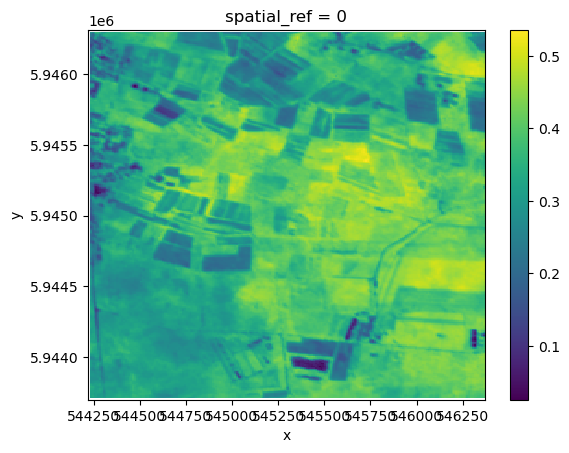

In [15]:
%%time
res.plot()

(Compare-to-other-sources)=
## Compare to other sources
We'll reuse the process graph we have created and only change the URL to the STAC API to use other sources of input.

In [16]:
def load_ndvi_mean(stac_url, bbox, time_range, bands, time_dim):
    cube = connection.load_stac(
        url=stac_url,
        spatial_extent = {
            "west": bbox[0],
            "south": bbox[1],
            "east": bbox[2],
            "north": bbox[3],
        },
        temporal_extent=time_range,
        bands=bands,
    )

    red = cube.band(bands[0])
    nir = cube.band(bands[1])
    cube_ndvi = (nir - red) / (nir + red)
    cube_mnth = cube_ndvi.reduce_dimension(dimension=time_dim, reducer="mean")
    return cube_mnth
    

### CDSE - Doesn't work without connection to the backend see below

In [21]:
stac_url = "https://stac.dataspace.copernicus.eu/v1/collections/sentinel-2-l2a/" # safe
bands = ["B02_10m", "B08_10m"]
cube_mnth = load_ndvi_mean(stac_url, bbox, time_range, bands, time_dim = "time")
# ValueError: The asset must have the following fields (from the projection extension): shape, transform, and one of an epsg, wkt2, or projjson --> it seemst that they are present in the item assets
# maybe this is due to auth

ValueError: The asset must have the following fields (from the projection extension): shape, transform, and one of an epsg, wkt2, or projjson

In [22]:
%%time
#res_cdse = cube_mnth.execute()
#res_cdse

CPU times: user 6 μs, sys: 0 ns, total: 6 μs
Wall time: 10 μs


In [23]:
%%time
#res_cdse.plot()

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.2 μs


### Element 84 Earth Search - Would need scaling

In [24]:
stac_url = "https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a" # jp2
bands = ["red", "nir08"]
cube_mnth = load_ndvi_mean(stac_url, bbox, time_range, bands, time_dim = "time")

In [25]:
%%time
res_el84 = cube_mnth.execute()
res_el84

CPU times: user 269 ms, sys: 3.73 ms, total: 273 ms
Wall time: 2.96 s


<xarray.DataArray (y: 259, x: 214)> Size: 443kB
dask.array<mean_agg-aggregate, shape=(259, 214), dtype=float64, chunksize=(259, 214), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 5.946e+06 5.946e+06 ... 5.944e+06 5.944e+06
  * x            (x) float64 2kB 5.442e+05 5.442e+05 ... 5.464e+05 5.464e+05
    spatial_ref  int32 4B 32632
Attributes: (1)

In [27]:
%%time
res_el84.plot()
# toDo: Check Scaling! There is probably something wrong with the values or scaling or outliers?

CPU times: user 1min 8s, sys: 5.87 s, total: 1min 13s
Wall time: 1min 51s


KeyboardInterrupt: 

### MS Planetary Computer
MS Planetary Computer is a stable source of satellite data made available via a STAC API. The Sentinel-2 L2A data has been transformed to **Cloud Optimized GeoTiffs (COG)** in this collection.

In [18]:
stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a" # cog
bands = ["B02", "B08"]
cube_mnth = load_ndvi_mean(stac_url, bbox, time_range, bands, time_dim = "time")

The spatial extents are slightly different than what we have received from the EOPF STAC API. This might be due to the conversion to COGs.

In [19]:
%%time
res_mspc = cube_mnth.execute()
res_mspc

CPU times: user 190 ms, sys: 3.91 ms, total: 193 ms
Wall time: 8.7 s


<xarray.DataArray (y: 259, x: 214)> Size: 222kB
dask.array<mean_agg-aggregate, shape=(259, 214), dtype=float32, chunksize=(259, 214), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 5.946e+06 5.946e+06 ... 5.944e+06 5.944e+06
  * x            (x) float64 2kB 5.442e+05 5.442e+05 ... 5.464e+05 5.464e+05
    spatial_ref  int32 4B 32632
Attributes: (1)

CPU times: user 3min 39s, sys: 7.72 s, total: 3min 46s
Wall time: 1min 47s


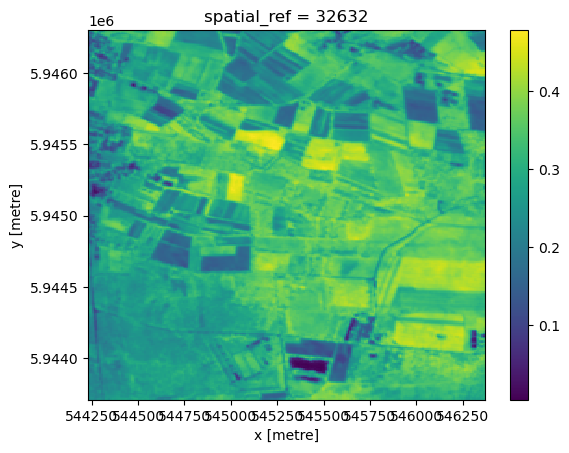

In [20]:
%%time
res_mspc.plot()

Let's check the differences of the two results.

In [21]:
%%time
diff = res_mspc - res
diff.to_series().describe()

CPU times: user 3min 48s, sys: 8.13 s, total: 3min 56s
Wall time: 1min 52s


count    55426.000000
mean        -0.055157
std          0.025907
min         -0.172499
25%         -0.071017
50%         -0.054587
75%         -0.037149
max          0.036408
dtype: float64

## Via openEO on CDSE

Connect to openEO on CDSE.

In [22]:
import openeo

In [24]:
connection_url = "openeo.dataspace.copernicus.eu"
connection = openeo.connect(connection_url).authenticate_oidc()

Authenticated using refresh token.


In [ ]:
# this cell needs to be deleted, but the behavior is interesting
stac_url = "https://stac.dataspace.copernicus.eu/v1/collections/sentinel-2-l2a/" # safe
bands = ["B02_10m", "B08_10m"] # these are the bandnames suggested when not connected to the backend
cube_mnth = load_ndvi_mean(stac_url, bbox, time_range, bands, time_dim = "time")
# The specified bands ['B02_10m', 'B08_10m'] in `load_stac` are not a subset of the bands ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12'] found in the STAC metadata (unknown bands: ['B02_10m', 'B08_10m']). Working with specified bands as is.
# ValueError: Invalid dimension 'time'. Should be one of ['x', 'y', 't']
# Strange that the behavior of load_stac connecting to the same stac_url changes, whether connceted to the cdse backend or local processing.
# When trying this via terrabyte it gives again a different error.

In [29]:
stac_url = "https://stac.dataspace.copernicus.eu/v1/collections/sentinel-2-l2a/" # safe
bands = ["B02", "B08"]
cube_mnth = load_ndvi_mean(stac_url, bbox, time_range, bands, time_dim = "t")

Since we're connected to the CDSE openEO backend we need to download the result (only JSON can be received via .exectue()).

In [34]:
%%time
# res_cdse_backend = cube_mnth.execute()
res_cdse_backend = cube_mnth.download("res_cdse_backend.tif")

CPU times: user 1.41 ms, sys: 7.9 ms, total: 9.31 ms
Wall time: 14.8 s


In [35]:
res_cdse_backend = rxr.open_rasterio("res_cdse_backend.tif")

Here we get the same extents as from EOPF.

In [36]:
res_cdse_backend

<xarray.DataArray (band: 1, y: 261, x: 215)> Size: 224kB
[56115 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB 5.442e+05 5.442e+05 ... 5.464e+05 5.464e+05
  * y            (y) float64 2kB 5.946e+06 5.946e+06 ... 5.944e+06 5.944e+06
    spatial_ref  int64 8B 0
Attributes: (5)

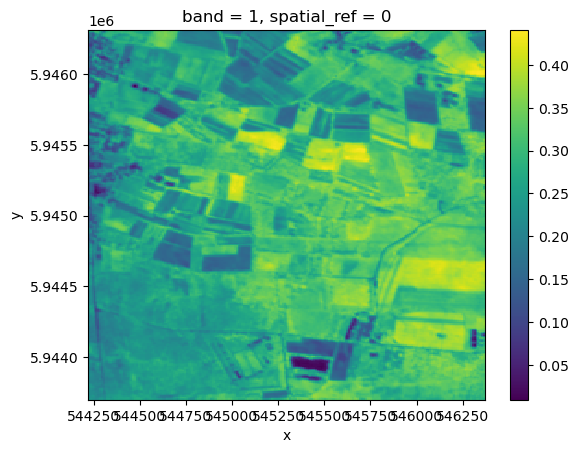

In [37]:
res_cdse_backend.plot()

Let's check the differences. Very marginal, probably due to different software processeors used to produce SAFE and EOPF.

In [39]:
diff2 = res - res_cdse_backend
diff2.to_series().describe()

count    55426.000000
mean         0.078158
std          0.023538
min         -0.006268
25%          0.062287
50%          0.077005
75%          0.092643
max          0.174986
dtype: float64

### CDSE Backend via load_collection() - We're probably not going to need to show this.

In [40]:
cube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent = {
        "west": bbox[0],
        "south": bbox[1],
        "east": bbox[2],
        "north": bbox[3],
    },
    temporal_extent=time_range,
    bands=bands,
)

In [41]:
red = cube.band(bands[0])
nir = cube.band(bands[1])
cube_ndvi = (nir - red) / (nir + red)
cube_mnth = cube_ndvi.reduce_dimension(dimension="t", reducer="mean")

In [43]:
%%time
cube_mnth.download("res_cdse_backend2.tif")

CPU times: user 2.06 ms, sys: 7.63 ms, total: 9.69 ms
Wall time: 14.8 s


In [44]:
res_cdse_backend2 = rxr.open_rasterio("res_cdse_backend2.tif")

In [45]:
res_cdse_backend2

<xarray.DataArray (band: 1, y: 261, x: 215)> Size: 224kB
[56115 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB 5.442e+05 5.442e+05 ... 5.464e+05 5.464e+05
  * y            (y) float64 2kB 5.946e+06 5.946e+06 ... 5.944e+06 5.944e+06
    spatial_ref  int64 8B 0
Attributes: (5)

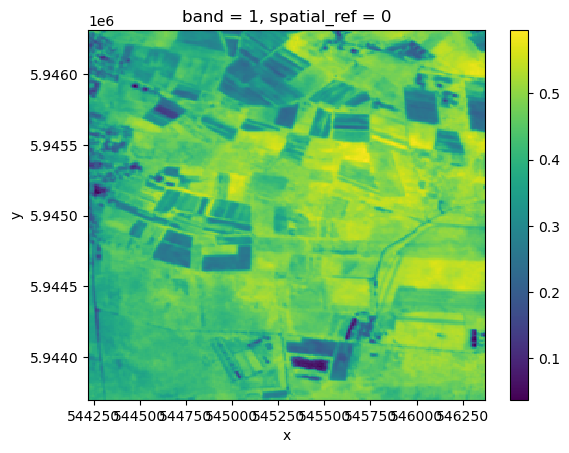

In [46]:
res_cdse_backend2.plot()

In [47]:
diff3 = res - res_cdse_backend2
diff3.to_series().describe()

count    55426.000000
mean        -0.072922
std          0.025527
min         -0.152845
25%         -0.084007
50%         -0.069137
75%         -0.057477
max          0.016201
dtype: float64

In [49]:
# getting data via load_stac() and load_collection() on CDSE from the same backend gives slightly different results. Maybe due to how the data is loaded by the two functions in the backend?
diff4 = res_cdse_backend - res_cdse_backend2
diff4.to_series().describe()

count    56115.000000
mean        -0.150925
std          0.027817
min         -0.228866
25%         -0.170541
50%         -0.152592
75%         -0.135329
max         -0.008979
dtype: float64